In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
bgr = pd.read_csv('board_games.csv')
bgr = bgr[bgr['users_rated'] != 0]
bgr.head(10)

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943
5,31260,boardgame,Agricola,2007.0,1.0,5.0,150.0,30.0,150.0,12.0,39714,8.11957,8.03847,47522,837,958,6402,9310,5065,3.6160
6,124742,boardgame,Android: Netrunner,2012.0,2.0,2.0,45.0,45.0,45.0,14.0,15281,8.16760,7.97822,24381,680,627,3244,3202,1260,3.3103
7,96848,boardgame,Mage Knight Board Game,2011.0,1.0,4.0,150.0,150.0,150.0,14.0,12697,8.15901,7.96929,18769,367,1116,5427,2861,1409,4.1292
8,84876,boardgame,The Castles of Burgundy,2011.0,2.0,4.0,90.0,30.0,90.0,12.0,15461,8.07879,7.95011,20558,215,929,3681,3244,1176,3.0442
9,72125,boardgame,Eclipse,2011.0,2.0,6.0,200.0,60.0,200.0,14.0,15709,8.07933,7.93244,17611,273,1108,5581,3188,1486,3.6359


# Determining An Error Metric

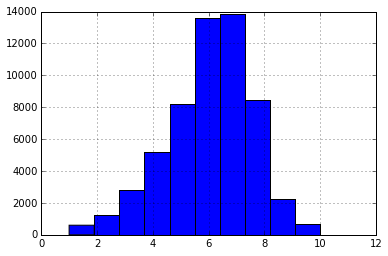

stddev: 1.57855225734 
 mean: 6.01591084856


In [2]:
bgr.average_rating.hist()
plt.show()

print('stddev:',bgr.average_rating.std(),'\n', 'mean:',bgr.average_rating.mean())

With the games with an average score of 0.0 removed from the dataset, a normal distribution appears to fit the data nicely. Because the distribution appears to be continuous, a metric such as absolute error or RMS error are good options. To penalize larger errors, we'll move forward with MSE as the error metric of choice.

# Clustering

In [3]:
from sklearn.cluster import KMeans
bgr = bgr.dropna()
numeric_columns = list(bgr.columns[3:])
kmc = KMeans(n_clusters=5)
kmc.fit(bgr[numeric_columns])
labels = kmc.labels_

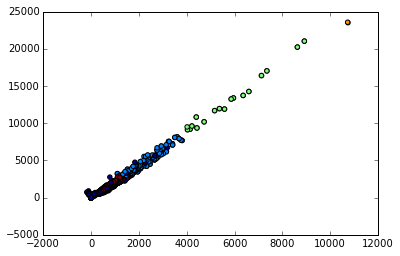

In [4]:
def rowmean(row):
    return row.mean()
def rowstd(row):
    return row.std()

game_mean = bgr[numeric_columns].apply(rowmean,axis=1)
game_std = bgr[numeric_columns].apply(rowstd,axis=1)
plt.scatter(game_mean,game_std,c=labels)
plt.show()
#print(len(game_mean),len(labels))

There's a very strong correlations between the average and the standard deviation of this data. This indicates that a higher rating also entails a larger quantity of reviews. It appears that games have been grouped pretty similarly to how they are scattered above. It's still not clear which columns are strongly correlated though, as this is an aggregate of all of the numerical data available.

# Reviewing Column Correlations

In [5]:
correlations = bgr[numeric_columns].corr()
correlations['average_rating']

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64

I'm surprised that correlations with yearpublished adn total_owners are so similar. I'm not sure I understand why that is the case. I'm also surprised that the bayes_average_rating correlation is relatively low, but it must me removed because it corresponds with average_rating and would cause overfitting if left in. 
I think the minimum player age value is especially interesting as it shows that a games for older players get higher ratings. Additionally, player quantities show that games with fewer players are slightly preferred, if at all, over games with more players

# Model Creation
In this attempt at creating a model, training and test subsets will not be used and instead we'll simply evaluate the model's capability based on the whole dataset

In [13]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
rel_cols = numeric_columns
rel_cols.remove("average_rating")
rel_cols.remove('bayes_average_rating')
reg.fit(bgr[rel_cols],bgr['average_rating'])
preds = reg.predict(bgr[rel_cols])

In [14]:
rel_cols

['yearpublished',
 'minplayers',
 'maxplayers',
 'playingtime',
 'minplaytime',
 'maxplaytime',
 'minage',
 'users_rated',
 'total_owners',
 'total_traders',
 'total_wanters',
 'total_wishers',
 'total_comments',
 'total_weights',
 'average_weight']

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(bgr['average_rating'],preds)

2.0933969758339361

# Conclusions From the MSE
The MSE indicates that our model isn't a great predictor, since it is about as large as standard deviation. 

# Next Steps

I look forward to coming back to this project and seperating the model into training and testing subsets, creating new predictors from the existing data, including a range of playing times, and a range of player sizes. It would also be interesting to apply decision trees, and folding the data to do so.